In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
from math import ceil
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params



dataset_name="caltech101"
 
model_name="EfficientNetb2_stn1"
version = "b2"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=10
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(res,res)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")


Model: EfficientNetb2_stn1 with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketc

In [2]:

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.localization = nn.Sequential(
            #nn.Conv2d(3, 8, kernel_size=7),
            nn.Conv2d(3,8,kernel_size=3),
            nn.Conv2d(8,8,kernel_size=3),
            nn.Conv2d(8,8,kernel_size=3),
            
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            
            
            #nn.Conv2d(8, 10, kernel_size=5),
            nn.Conv2d(8,10, kernel_size = 3),
            nn.Conv2d(10,10,kernel_size = 3),
            
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(37210, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )
        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)
        xs = xs.view(-1, 10 * 61 * 61)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        self.stn(x)
        x = self.pool(self.features(x))
        
        return self.classifier(x.view(x.shape[0], -1))


def test():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    version = "b2"
    phi, res, drop_rate = phi_values[version]
    num_examples = 4
    x = torch.randn((num_examples, 3, res, res)).to(device)
    model = EfficientNet(
        version=version,
        num_classes=num_classes,
    ).to(device)
    print(x.shape)
    print(model(x).shape) # (num_examples, num_classes)

test()

#print("Efficient Net model defined")

torch.Size([4, 3, 260, 260])
torch.Size([4, 101])


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [3]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

from thop import profile
import colorama
from colorama import Fore,Style
#vital params
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, res, res).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)

#pretesting model for shape
x=torch.randn(batch_size,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CNNBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Sigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SqueezeExcitation'>. Treat it as zero 

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)



        CNNBlock-301           [-1, 1272, 9, 9]               0
          Conv2d-302           [-1, 1272, 9, 9]          31,800
     BatchNorm2d-303           [-1, 1272, 9, 9]           2,544
            SiLU-304           [-1, 1272, 9, 9]               0
        CNNBlock-305           [-1, 1272, 9, 9]               0
AdaptiveAvgPool2d-306           [-1, 1272, 1, 1]               0
          Conv2d-307             [-1, 53, 1, 1]          67,469
            SiLU-308             [-1, 53, 1, 1]               0
          Conv2d-309           [-1, 1272, 1, 1]          68,688
         Sigmoid-310           [-1, 1272, 1, 1]               0
SqueezeExcitation-311           [-1, 1272, 9, 9]               0
          Conv2d-312            [-1, 212, 9, 9]         269,664
     BatchNorm2d-313            [-1, 212, 9, 9]             424
InvertedResidualBlock-314            [-1, 212, 9, 9]               0
          Conv2d-315           [-1, 1272, 9, 9]       2,426,976
     BatchNorm2d-316           [

In [4]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [5]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb2_stn120211225220355
grandstore_string:
grandstore/caltech101_EfficientNetb2_stn120211225220355.pkl


In [6]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [7]:
TOP_ACCURACY_TRACK = 12
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=350,
                    minepoch=200,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                 
                   )

Running epoch: 1


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 14.750
Training Loss: 8506027.6213 	Validation Loss: 4978.1892

Running epoch: 2


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 25.417
Training Loss: 7787719.9994 	Validation Loss: 4235.5669

Running epoch: 3


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 31.917
Training Loss: 6800203.5979 	Validation Loss: 3756.4967

Running epoch: 4


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 36.417
Training Loss: 5928981.9070 	Validation Loss: 3391.3415

Running epoch: 5


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 40.833
Training Loss: 5371953.0210 	Validation Loss: 3076.5399

Running epoch: 6


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 44.750
Training Loss: 5003872.1157 	Validation Loss: 2938.5256

Running epoch: 7


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 45.167
Training Loss: 4607553.2044 	Validation Loss: 2973.2167

Running epoch: 8


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 48.333
Training Loss: 4227574.8001 	Validation Loss: 2603.6196

Running epoch: 9


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 52.083
Training Loss: 3867703.7620 	Validation Loss: 2489.8813

Running epoch: 10


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 53.500
Training Loss: 3546825.5609 	Validation Loss: 2417.7252

Running epoch: 11


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.333
Training Loss: 3262726.9195 	Validation Loss: 2244.9371

Running epoch: 12


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 58.000
Training Loss: 2919521.7077 	Validation Loss: 2115.0799

Running epoch: 13


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.083
Training Loss: 2660445.6296 	Validation Loss: 2027.8390

Running epoch: 14


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 58.083
Training Loss: 2335160.5068 	Validation Loss: 2123.2049

Running epoch: 15


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 1989984.8738 	Validation Loss: 2004.7364

Running epoch: 16


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.250
Training Loss: 1710461.7617 	Validation Loss: 2033.1853

Running epoch: 17


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.667
Training Loss: 1481557.4288 	Validation Loss: 1986.8028

Running epoch: 18


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.333
Training Loss: 1216483.5060 	Validation Loss: 2015.9936

Running epoch: 19


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.250
Training Loss: 1050842.3753 	Validation Loss: 2153.7848

Running epoch: 20


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.167
Training Loss: 809850.0474 	Validation Loss: 2095.0804

Running epoch: 21


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.667
Training Loss: 665441.5448 	Validation Loss: 2253.4518

Running epoch: 22


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.833
Training Loss: 641430.9186 	Validation Loss: 2226.1804

Running epoch: 23


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.167
Training Loss: 582102.1626 	Validation Loss: 2276.3560

Running epoch: 24


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.833
Training Loss: 442988.8521 	Validation Loss: 2420.0037

Running epoch: 25


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.250
Training Loss: 449826.8296 	Validation Loss: 2453.0652

Running epoch: 26


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.750
Training Loss: 373954.1211 	Validation Loss: 2489.3391

Running epoch: 27


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.500
Training Loss: 372477.7494 	Validation Loss: 2658.9207

Running epoch: 28


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.667
Training Loss: 332705.3179 	Validation Loss: 2663.4262

Running epoch: 29


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.417
Training Loss: 333335.6804 	Validation Loss: 2488.4325

Running epoch: 30


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.667
Training Loss: 282750.4989 	Validation Loss: 2635.8298

Running epoch: 31


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.917
Training Loss: 282998.7704 	Validation Loss: 2640.7585

Running epoch: 32


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.833
Training Loss: 336847.9270 	Validation Loss: 2656.4483

Running epoch: 33


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 246095.3853 	Validation Loss: 2562.7705

Running epoch: 34


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.000
Training Loss: 241058.8003 	Validation Loss: 2605.8326

Running epoch: 35


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 203243.6826 	Validation Loss: 2623.2703

Running epoch: 36


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.917
Training Loss: 274458.1925 	Validation Loss: 2718.7065

Running epoch: 37


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 209348.4347 	Validation Loss: 2800.9338

Running epoch: 38


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.167
Training Loss: 207044.1566 	Validation Loss: 2775.6349

Running epoch: 39


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.833
Training Loss: 223842.6030 	Validation Loss: 2681.7745

Running epoch: 40


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.000
Training Loss: 226041.0929 	Validation Loss: 2825.9317

Running epoch: 41


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.083
Training Loss: 214338.2930 	Validation Loss: 2737.5395

Running epoch: 42


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.833
Training Loss: 181497.1217 	Validation Loss: 2920.3631

Running epoch: 43


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.000
Training Loss: 193357.9168 	Validation Loss: 2692.7914

Running epoch: 44


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 61.750
Training Loss: 175742.4642 	Validation Loss: 2947.1372

Running epoch: 45


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.333
Training Loss: 182344.9611 	Validation Loss: 2830.0826

Running epoch: 46


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.833
Training Loss: 165321.3706 	Validation Loss: 2847.2512

Running epoch: 47


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 157329.4341 	Validation Loss: 2869.9663

Running epoch: 48


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.333
Training Loss: 159059.7763 	Validation Loss: 2882.7116

Running epoch: 49


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.833
Training Loss: 106907.2942 	Validation Loss: 3133.1565

Running epoch: 50


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.417
Training Loss: 176916.5189 	Validation Loss: 2903.5223

Running epoch: 51


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 141650.8270 	Validation Loss: 2888.7317

Running epoch: 52


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.500
Training Loss: 151249.1731 	Validation Loss: 2977.5301

Running epoch: 53


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.917
Training Loss: 147998.3479 	Validation Loss: 2985.9210

Running epoch: 54


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.667
Training Loss: 106801.2241 	Validation Loss: 2997.1945

Running epoch: 55


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.833
Training Loss: 132688.7531 	Validation Loss: 2929.4295

Running epoch: 56


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.750
Training Loss: 107624.6172 	Validation Loss: 2889.6896

Running epoch: 57


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.000
Training Loss: 156436.4936 	Validation Loss: 2825.3633

Running epoch: 58


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.250
Training Loss: 114271.9312 	Validation Loss: 2857.1138

Running epoch: 59


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.417
Training Loss: 118477.1972 	Validation Loss: 2943.4842

Running epoch: 60


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.750
Training Loss: 121995.9227 	Validation Loss: 2943.7229

Running epoch: 61


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.250
Training Loss: 160199.5632 	Validation Loss: 2859.1644

Running epoch: 62


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.500
Training Loss: 97130.1735 	Validation Loss: 2973.5027

Running epoch: 63


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.500
Training Loss: 89230.1762 	Validation Loss: 2905.3088

Running epoch: 64


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.083
Training Loss: 89224.6522 	Validation Loss: 3026.4378

Running epoch: 65


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.000
Training Loss: 112215.0517 	Validation Loss: 2981.8902

Running epoch: 66


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 105182.3015 	Validation Loss: 2879.3014

Running epoch: 67


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.667
Training Loss: 100557.3132 	Validation Loss: 2980.2259

Running epoch: 68


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.333
Training Loss: 98274.9351 	Validation Loss: 2937.8251

Running epoch: 69


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.167
Training Loss: 94953.0111 	Validation Loss: 2994.8691

Running epoch: 70


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.250
Training Loss: 97225.8272 	Validation Loss: 3001.6598

Running epoch: 71


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.250
Training Loss: 95920.9293 	Validation Loss: 2989.5224

Running epoch: 72


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.667
Training Loss: 92680.1289 	Validation Loss: 2971.6557

Running epoch: 73


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 80207.0930 	Validation Loss: 2925.3449

Running epoch: 74


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.333
Training Loss: 62720.9829 	Validation Loss: 2913.1607

Running epoch: 75


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.833
Training Loss: 58884.0033 	Validation Loss: 3046.2539

Running epoch: 76


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.333
Training Loss: 78525.4985 	Validation Loss: 3110.1230

Running epoch: 77


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.500
Training Loss: 133264.4558 	Validation Loss: 2984.1262

Running epoch: 78


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.833
Training Loss: 73971.3510 	Validation Loss: 2965.5632

Running epoch: 79


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.333
Training Loss: 74998.1521 	Validation Loss: 3100.1498

Running epoch: 80


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.333
Training Loss: 79556.9632 	Validation Loss: 2929.5245

Running epoch: 81


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 62.917
Training Loss: 66685.7170 	Validation Loss: 3242.7105

Running epoch: 82


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.500
Training Loss: 97824.8494 	Validation Loss: 3069.8222

Running epoch: 83


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.833
Training Loss: 68571.9532 	Validation Loss: 3109.5791

Running epoch: 84


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.417
Training Loss: 65750.7467 	Validation Loss: 2996.1089

Running epoch: 85


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.083
Training Loss: 79834.7853 	Validation Loss: 3114.3029

Running epoch: 86


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 82705.3785 	Validation Loss: 3049.7450

Running epoch: 87


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.917
Training Loss: 78428.8081 	Validation Loss: 3110.7400

Running epoch: 88


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.083
Training Loss: 77000.4221 	Validation Loss: 3064.5039

Running epoch: 89


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.417
Training Loss: 57849.4170 	Validation Loss: 3052.2741

Running epoch: 90


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 72211.4592 	Validation Loss: 3048.6568

Running epoch: 91


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.667
Training Loss: 66966.0959 	Validation Loss: 3052.3648

Running epoch: 92


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 80107.6318 	Validation Loss: 2963.5856

Running epoch: 93


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.833
Training Loss: 56882.3752 	Validation Loss: 3057.7518

Running epoch: 94


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.833
Training Loss: 61980.8432 	Validation Loss: 2920.4790

Running epoch: 95


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 63.833
Training Loss: 82503.1159 	Validation Loss: 3131.5841

Running epoch: 96


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 74253.7816 	Validation Loss: 3008.7505

Running epoch: 97


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.833
Training Loss: 64393.0733 	Validation Loss: 3104.6055

Running epoch: 98


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.167
Training Loss: 85610.9458 	Validation Loss: 3046.1056

Running epoch: 99


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.083
Training Loss: 55499.1633 	Validation Loss: 3067.5581

Running epoch: 100


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.250
Training Loss: 50094.6364 	Validation Loss: 3022.6445

Running epoch: 101


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 69138.6191 	Validation Loss: 2980.7753

Running epoch: 102


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.167
Training Loss: 78654.8656 	Validation Loss: 3028.9636

Running epoch: 103


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 71520.6448 	Validation Loss: 3001.3861

Running epoch: 104


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 41287.8672 	Validation Loss: 2955.1413

Running epoch: 105


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.167
Training Loss: 60217.6711 	Validation Loss: 3059.1818

Running epoch: 106


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 52261.1108 	Validation Loss: 2976.8683

Running epoch: 107


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.250
Training Loss: 44575.1549 	Validation Loss: 3179.7807

Running epoch: 108


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.083
Training Loss: 46780.3560 	Validation Loss: 3218.8626

Running epoch: 109


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 67103.7704 	Validation Loss: 3269.4503

Running epoch: 110


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.667
Training Loss: 50226.2080 	Validation Loss: 3270.6353

Running epoch: 111


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 59205.7654 	Validation Loss: 3217.8511

Running epoch: 112


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.000
Training Loss: 38350.5940 	Validation Loss: 3249.3012

Running epoch: 113


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.167
Training Loss: 54404.0809 	Validation Loss: 3290.7224

Running epoch: 114


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 55322.3940 	Validation Loss: 3106.1728

Running epoch: 115


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 67336.7931 	Validation Loss: 3102.5700

Running epoch: 116


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 46902.1452 	Validation Loss: 3176.6593

Running epoch: 117


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 49285.1780 	Validation Loss: 3113.0327

Running epoch: 118


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 50793.2407 	Validation Loss: 3069.7126

Running epoch: 119


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 38219.7963 	Validation Loss: 3147.3843

Running epoch: 120


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.500
Training Loss: 60205.0290 	Validation Loss: 3231.6880

Running epoch: 121


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.083
Training Loss: 74083.8954 	Validation Loss: 3001.5005

Running epoch: 122


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.250
Training Loss: 35898.3666 	Validation Loss: 3044.9140

Running epoch: 123


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.250
Training Loss: 26627.6818 	Validation Loss: 3097.1784

Running epoch: 124


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.083
Training Loss: 49126.3671 	Validation Loss: 3160.2895

Running epoch: 125


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.083
Training Loss: 75466.9185 	Validation Loss: 2954.1697

Running epoch: 126


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 32418.1025 	Validation Loss: 3084.5858

Running epoch: 127


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.250
Training Loss: 51494.2376 	Validation Loss: 3127.9230

Running epoch: 128


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.250
Training Loss: 50853.2397 	Validation Loss: 3252.3145

Running epoch: 129


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 57090.0685 	Validation Loss: 3022.8499

Running epoch: 130


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.833
Training Loss: 44843.4959 	Validation Loss: 3083.9690

Running epoch: 131


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 28669.0623 	Validation Loss: 2948.8873

Running epoch: 132


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.667
Training Loss: 45215.9848 	Validation Loss: 3297.2301

Running epoch: 133


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.250
Training Loss: 27073.2429 	Validation Loss: 3317.9090

Running epoch: 134


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.583
Training Loss: 48999.7066 	Validation Loss: 3246.2031

Running epoch: 135


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 64.833
Training Loss: 64473.2378 	Validation Loss: 3224.8380

Running epoch: 136


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.833
Training Loss: 57220.7138 	Validation Loss: 3128.4056

Running epoch: 137


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 45631.7636 	Validation Loss: 3236.4800

Running epoch: 138


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.333
Training Loss: 33733.8937 	Validation Loss: 3136.8515

Running epoch: 139


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 35523.1911 	Validation Loss: 3213.1820

Running epoch: 140


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 49162.6390 	Validation Loss: 3204.7001

Running epoch: 141


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.083
Training Loss: 60111.0335 	Validation Loss: 3292.2026

Running epoch: 142


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 48109.5489 	Validation Loss: 3258.6194

Running epoch: 143


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 35712.1621 	Validation Loss: 3195.2912

Running epoch: 144


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 30739.0291 	Validation Loss: 3173.2423

Running epoch: 145


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 47243.4243 	Validation Loss: 3161.6225

Running epoch: 146


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 28202.9438 	Validation Loss: 3075.1360

Running epoch: 147


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.583
Training Loss: 70829.9065 	Validation Loss: 3138.6145

Running epoch: 148


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 40402.0103 	Validation Loss: 3090.7594

Running epoch: 149


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 34577.2184 	Validation Loss: 3282.3026

Running epoch: 150


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 44044.9725 	Validation Loss: 3112.6639

Running epoch: 151


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 39808.0915 	Validation Loss: 3103.8594

Running epoch: 152


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 33997.3629 	Validation Loss: 3042.3679

Running epoch: 153


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 40115.7971 	Validation Loss: 3182.4924

Running epoch: 154


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 39214.7276 	Validation Loss: 3110.2000

Running epoch: 155


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 46709.8184 	Validation Loss: 3090.7396

Running epoch: 156


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.083
Training Loss: 27525.2859 	Validation Loss: 3184.5716

Running epoch: 157


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 35066.2025 	Validation Loss: 3201.5159

Running epoch: 158


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 26444.3839 	Validation Loss: 3156.4387

Running epoch: 159


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 32756.6144 	Validation Loss: 3165.4182

Running epoch: 160


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 49893.8974 	Validation Loss: 3176.2862

Running epoch: 161


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 42274.7638 	Validation Loss: 3193.0898

Running epoch: 162


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 27123.0227 	Validation Loss: 3189.0872

Running epoch: 163


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 22467.4572 	Validation Loss: 3330.7381

Running epoch: 164


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 36838.1761 	Validation Loss: 3155.5026

Running epoch: 165


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 31305.8041 	Validation Loss: 3248.5191

Running epoch: 166


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 31015.8611 	Validation Loss: 3113.8998

Running epoch: 167


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 27803.7935 	Validation Loss: 3120.0491

Running epoch: 168


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 40805.6072 	Validation Loss: 3383.6872

Running epoch: 169


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 43971.0189 	Validation Loss: 3205.4157

Running epoch: 170


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 27069.9604 	Validation Loss: 3251.9967

Running epoch: 171


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 36833.4732 	Validation Loss: 3201.2224

Running epoch: 172


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 36517.8120 	Validation Loss: 3184.1251

Running epoch: 173


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 29941.6970 	Validation Loss: 3274.4005

Running epoch: 174


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 37186.3803 	Validation Loss: 3258.4511

Running epoch: 175


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 20354.5824 	Validation Loss: 3176.4247

Running epoch: 176


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 19711.3838 	Validation Loss: 3179.0060

Running epoch: 177


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 36546.9411 	Validation Loss: 3057.8207

Running epoch: 178


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 22767.5856 	Validation Loss: 3038.2283

Running epoch: 179


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 40432.9828 	Validation Loss: 3202.5013

Running epoch: 180


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 45272.5424 	Validation Loss: 3271.1565

Running epoch: 181


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 40752.1391 	Validation Loss: 3105.1169

Running epoch: 182


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 20878.0587 	Validation Loss: 3110.6050

Running epoch: 183


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 35840.9259 	Validation Loss: 3214.4380

Running epoch: 184


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 37650.3671 	Validation Loss: 2982.1316

Running epoch: 185


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 18794.9242 	Validation Loss: 3107.4223

Running epoch: 186


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 25168.4401 	Validation Loss: 3186.4010

Running epoch: 187


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 56049.4355 	Validation Loss: 3191.0492

Running epoch: 188


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 19857.6415 	Validation Loss: 3147.8288

Running epoch: 189


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.417
Training Loss: 10927.0131 	Validation Loss: 3344.0883

Running epoch: 190


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.250
Training Loss: 45156.8630 	Validation Loss: 3166.0712

Running epoch: 191


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 38093.9002 	Validation Loss: 3080.4162

Running epoch: 192


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 44396.8736 	Validation Loss: 3100.7198

Running epoch: 193


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 28655.3373 	Validation Loss: 3021.3442

Running epoch: 194


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.083
Training Loss: 46558.8832 	Validation Loss: 3113.9696

Running epoch: 195


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 24858.7542 	Validation Loss: 3113.2390

Running epoch: 196


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 33435.3615 	Validation Loss: 3135.4056

Running epoch: 197


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 45982.4965 	Validation Loss: 3108.7812

Running epoch: 198


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 28975.4694 	Validation Loss: 3147.1662

Running epoch: 199


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.667
Training Loss: 28443.8368 	Validation Loss: 3294.1345

Running epoch: 200


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 20117.6956 	Validation Loss: 3309.1777

Running epoch: 201


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 36699.4516 	Validation Loss: 3323.1222

Running epoch: 202


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.750
Training Loss: 29574.6351 	Validation Loss: 3151.2433

Running epoch: 203


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 14525.6392 	Validation Loss: 3291.2047

Running epoch: 204


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 34135.7420 	Validation Loss: 3230.9015

Running epoch: 205


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 18992.5325 	Validation Loss: 3292.3069

Running epoch: 206


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 21318.8406 	Validation Loss: 3302.8773

Running epoch: 207


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 29268.0347 	Validation Loss: 3370.8945

Running epoch: 208


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.083
Training Loss: 44273.1830 	Validation Loss: 3198.3622

Running epoch: 209


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 27152.5607 	Validation Loss: 3299.7613

Running epoch: 210


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 38591.4556 	Validation Loss: 3327.3343

Running epoch: 211


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 26359.3493 	Validation Loss: 3343.4142

Running epoch: 212


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 27731.0887 	Validation Loss: 3255.1904

Running epoch: 213


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 26647.8570 	Validation Loss: 3182.9108

Running epoch: 214


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 29148.5414 	Validation Loss: 3082.1593

Running epoch: 215


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.333
Training Loss: 39847.9415 	Validation Loss: 3327.5219

Running epoch: 216


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 34762.9422 	Validation Loss: 3265.8731

Running epoch: 217


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 22369.4199 	Validation Loss: 3126.3144

Running epoch: 218


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 22014.3763 	Validation Loss: 3157.4393

Running epoch: 219


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 22793.0840 	Validation Loss: 3139.7442

Running epoch: 220


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 33871.8467 	Validation Loss: 3090.7594

Running epoch: 221


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.417
Training Loss: 24073.8637 	Validation Loss: 3168.2876

Running epoch: 222


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 21722.8357 	Validation Loss: 3011.2723

Running epoch: 223


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 21270.0879 	Validation Loss: 3153.1532

Running epoch: 224


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 27933.6639 	Validation Loss: 3326.2703

Running epoch: 225


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 16813.7070 	Validation Loss: 3207.2854

Running epoch: 226


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 30560.3570 	Validation Loss: 3284.0560

Running epoch: 227


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 30652.4082 	Validation Loss: 3383.5493

Running epoch: 228


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 28695.3788 	Validation Loss: 3298.5791

Running epoch: 229


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 26514.0781 	Validation Loss: 3164.9140

Running epoch: 230


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 32316.8140 	Validation Loss: 3313.1594

Running epoch: 231


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 19250.9213 	Validation Loss: 3272.9609

Running epoch: 232


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 26638.3738 	Validation Loss: 3199.0258

Running epoch: 233


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 31573.5243 	Validation Loss: 3247.0566

Running epoch: 234


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 25935.5978 	Validation Loss: 3323.8913

Running epoch: 235


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 24009.8047 	Validation Loss: 3135.2812

Running epoch: 236


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.833
Training Loss: 20076.8876 	Validation Loss: 3191.4687

Running epoch: 237


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 29482.1135 	Validation Loss: 3187.1362

Running epoch: 238


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 14380.0444 	Validation Loss: 3123.2316

Running epoch: 239


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 18525.3867 	Validation Loss: 3061.8766

Running epoch: 240


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.000
Training Loss: 32255.8689 	Validation Loss: 3211.9425

Running epoch: 241


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 32127.7788 	Validation Loss: 3036.0598

Running epoch: 242


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 13479.1240 	Validation Loss: 3038.5002

Running epoch: 243


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 23742.4249 	Validation Loss: 3096.5790

Running epoch: 244


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 15875.1727 	Validation Loss: 3225.0313

Running epoch: 245


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 28776.0401 	Validation Loss: 3179.4650

Running epoch: 246


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 30615.5832 	Validation Loss: 3192.7764

Running epoch: 247


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 18860.7148 	Validation Loss: 3244.1017

Running epoch: 248


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 17098.9283 	Validation Loss: 3187.6609

Running epoch: 249


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 37732.6991 	Validation Loss: 3092.4203

Running epoch: 250


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 22874.8400 	Validation Loss: 3083.0234

Running epoch: 251


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.750
Training Loss: 25986.0440 	Validation Loss: 3082.6379

Running epoch: 252


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.667
Training Loss: 29067.4406 	Validation Loss: 3214.9465

Running epoch: 253


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 18230.3498 	Validation Loss: 3029.7407

Running epoch: 254


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 20584.8801 	Validation Loss: 3188.2664

Running epoch: 255


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 33259.4641 	Validation Loss: 3294.4607

Running epoch: 256


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 20250.8745 	Validation Loss: 3077.4324

Running epoch: 257


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.250
Training Loss: 13103.6445 	Validation Loss: 3072.7053

Running epoch: 258


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 13430.8815 	Validation Loss: 3285.7465

Running epoch: 259


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 16192.7550 	Validation Loss: 3356.8416

Running epoch: 260


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 35852.5185 	Validation Loss: 3271.1127

Running epoch: 261


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 28242.7790 	Validation Loss: 3384.2461

Running epoch: 262


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 26389.6373 	Validation Loss: 3356.7962

Running epoch: 263


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 15468.8753 	Validation Loss: 3197.1424

Running epoch: 264


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 17464.2080 	Validation Loss: 3296.8540

Running epoch: 265


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.833
Training Loss: 18860.8823 	Validation Loss: 3137.2972

Running epoch: 266


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 14534.9317 	Validation Loss: 3193.9734

Running epoch: 267


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 28280.0567 	Validation Loss: 3293.3247

Running epoch: 268


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 16892.2723 	Validation Loss: 3266.8098

Running epoch: 269


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 23309.3292 	Validation Loss: 3360.2322

Running epoch: 270


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 11060.1768 	Validation Loss: 3239.3613

Running epoch: 271


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 17101.0777 	Validation Loss: 3578.7684

Running epoch: 272


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 31347.4300 	Validation Loss: 3403.4147

Running epoch: 273


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 20720.4512 	Validation Loss: 3519.9574

Running epoch: 274


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 20932.5723 	Validation Loss: 3281.1599

Running epoch: 275


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 29529.5280 	Validation Loss: 3438.0230

Running epoch: 276


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 15421.1649 	Validation Loss: 3458.3708

Running epoch: 277


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 24442.8076 	Validation Loss: 3376.4185

Running epoch: 278


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 22140.8939 	Validation Loss: 3480.7210

Running epoch: 279


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 18327.2927 	Validation Loss: 3515.5634

Running epoch: 280


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 14973.4361 	Validation Loss: 3495.1654

Running epoch: 281


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 16975.2857 	Validation Loss: 3428.1529

Running epoch: 282


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 35296.5976 	Validation Loss: 3336.5053

Running epoch: 283


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 18389.7939 	Validation Loss: 3282.3288

Running epoch: 284


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 12951.3668 	Validation Loss: 3281.9458

Running epoch: 285


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.917
Training Loss: 25793.1154 	Validation Loss: 3236.8682

Running epoch: 286


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 10311.4379 	Validation Loss: 3478.7936

Running epoch: 287


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.833
Training Loss: 34812.1884 	Validation Loss: 3431.0535

Running epoch: 288


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 13568.8602 	Validation Loss: 3370.0910

Running epoch: 289


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.583
Training Loss: 18189.8635 	Validation Loss: 3163.0513

Running epoch: 290


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 28742.3605 	Validation Loss: 3464.0265

Running epoch: 291


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 15738.5706 	Validation Loss: 3287.5593

Running epoch: 292


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 29605.6735 	Validation Loss: 3310.5330

Running epoch: 293


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 26669.3139 	Validation Loss: 3528.6461

Running epoch: 294


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.667
Training Loss: 22205.7575 	Validation Loss: 3271.4883

Running epoch: 295


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 10635.0646 	Validation Loss: 3411.3685

Running epoch: 296


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.750
Training Loss: 25557.3024 	Validation Loss: 3412.2452

Running epoch: 297


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.250
Training Loss: 15633.7594 	Validation Loss: 3372.3599

Running epoch: 298


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 10245.0643 	Validation Loss: 3493.3967

Running epoch: 299


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 29574.8427 	Validation Loss: 3284.8033

Running epoch: 300


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 31352.3244 	Validation Loss: 3159.1928

Running epoch: 301


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 13065.7951 	Validation Loss: 3257.5953

Running epoch: 302


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 21268.0109 	Validation Loss: 3334.6532

Running epoch: 303


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 26279.6196 	Validation Loss: 3460.4300

Running epoch: 304


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.083
Training Loss: 10633.1325 	Validation Loss: 3452.3186

Running epoch: 305


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 18156.2455 	Validation Loss: 3453.5965

Running epoch: 306


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.167
Training Loss: 16048.4376 	Validation Loss: 3362.1783

Running epoch: 307


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 19352.9862 	Validation Loss: 3301.2387

Running epoch: 308


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 16535.9552 	Validation Loss: 3451.5831

Running epoch: 309


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 31877.5280 	Validation Loss: 3406.5614

Running epoch: 310


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 15873.4985 	Validation Loss: 3269.7387

Running epoch: 311


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 15280.2532 	Validation Loss: 3349.7022

Running epoch: 312


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 30373.3911 	Validation Loss: 3404.1780

Running epoch: 313


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.333
Training Loss: 14081.6828 	Validation Loss: 3425.8384

Running epoch: 314


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 23643.8915 	Validation Loss: 3242.4849

Running epoch: 315


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 10480.1564 	Validation Loss: 3279.8301

Running epoch: 316


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.417
Training Loss: 24773.5945 	Validation Loss: 3474.3015

Running epoch: 317


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.750
Training Loss: 15508.8724 	Validation Loss: 3430.7331

Running epoch: 318


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 17508.1538 	Validation Loss: 3478.5701

Running epoch: 319


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.917
Training Loss: 9477.0147 	Validation Loss: 3559.0058

Running epoch: 320


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 20034.3578 	Validation Loss: 3535.6238

Running epoch: 321


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 28541.6133 	Validation Loss: 3322.1268

Running epoch: 322


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 20256.1977 	Validation Loss: 3379.3852

Running epoch: 323


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.417
Training Loss: 13685.4371 	Validation Loss: 3455.4459

Running epoch: 324


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 13576.2993 	Validation Loss: 3474.6677

Running epoch: 325


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 23754.9531 	Validation Loss: 3510.9531

Running epoch: 326


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.583
Training Loss: 25312.0785 	Validation Loss: 3666.9763

Running epoch: 327


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 65.833
Training Loss: 27986.9150 	Validation Loss: 3624.7451

Running epoch: 328


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 23156.4463 	Validation Loss: 3433.1821

Running epoch: 329


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 13691.1627 	Validation Loss: 3374.0216

Running epoch: 330


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 10049.8088 	Validation Loss: 3484.8558

Running epoch: 331


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.167
Training Loss: 22516.9662 	Validation Loss: 3390.8744

Running epoch: 332


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.000
Training Loss: 24051.0133 	Validation Loss: 3529.8244

Running epoch: 333


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.083
Training Loss: 37660.8480 	Validation Loss: 3419.4904

Running epoch: 334


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.000
Training Loss: 17392.5388 	Validation Loss: 3357.6926

Running epoch: 335


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 12415.1701 	Validation Loss: 3394.9763

Running epoch: 336


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.583
Training Loss: 20325.3619 	Validation Loss: 3581.9797

Running epoch: 337


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 17752.3211 	Validation Loss: 3281.4094

Running epoch: 338


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.167
Training Loss: 15891.9990 	Validation Loss: 3533.0417

Running epoch: 339


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 16522.1870 	Validation Loss: 3363.3704

Running epoch: 340


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 25612.5191 	Validation Loss: 3564.2889

Running epoch: 341


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.917
Training Loss: 12490.8443 	Validation Loss: 3570.3739

Running epoch: 342


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 14779.3854 	Validation Loss: 3539.3511

Running epoch: 343


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 20751.6165 	Validation Loss: 3471.4104

Running epoch: 344


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.083
Training Loss: 26956.9093 	Validation Loss: 3313.8026

Running epoch: 345


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 8411.2670 	Validation Loss: 3432.5002

Running epoch: 346


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 66.333
Training Loss: 26151.0338 	Validation Loss: 3577.7698

Running epoch: 347


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 13525.1341 	Validation Loss: 3516.8472

Running epoch: 348


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.917
Training Loss: 17341.8475 	Validation Loss: 3456.2110

Running epoch: 349


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 67.333
Training Loss: 4923.9529 	Validation Loss: 3534.3202

Running epoch: 350


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.500
Training Loss: 11407.0646 	Validation Loss: 3590.7873



Total Run 350 epoch(s)
Accuracy MIN: 14.75 / MAX: 69.58333333333333

Top 12 performing epochs:
#1 epoch 289	||train_acc 69.58%	||test 67.17%
#2 epoch 242	||train_acc 69.25%	||test 67.75%
#3 epoch 241	||train_acc 69.25%	||test 66.58%
#4 epoch 344	||train_acc 69.08%	||test 67.92%
#5 epoch 253	||train_acc 69.00%	||test 68.50%
#6 epoch 249	||train_acc 69.00%	||test 67.33%
#7 epoch 285	||train_acc 68.92%	||test 68.33%
#8 epoch 265	||train_acc 68.83%	||test 67.75%
#9 epoch 202	||train_acc 68.75%	||test 67.33%
#10 epoch 251	||train_acc 68.75%	||test 67.00%
#11 epoch 294	||train_acc 68.67%	||test 66.75%
#12 epoch 252	||train_acc 68.67%	||test 66.25%

Last epoch:
epoch 350	||train_acc 66.50%	||test 67.67%

The model has parameters: 30809559


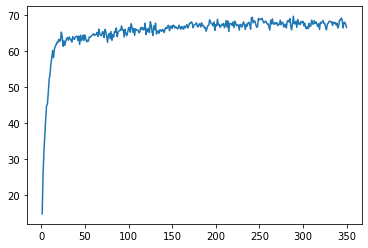

In [8]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [9]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/caltech101_EfficientNetb2_stn120211225220355.pkl
